In [2]:
pip install darts torch

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TFTModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse


torch.set_default_dtype(torch.float32)
torch.backends.mps.allow_fp64 = False

In [7]:
df = pd.read_csv(
    "../dataa/electricity_features_hourly.csv",  
    parse_dates=["Date"]
)


df = df.sort_values("Date").reset_index(drop=True)

for col in df.columns:
    if col != "Date":
        df[col] = df[col].astype(np.float32)

# Apple MPS float64 desteklemez.
# Bu yüzden tüm tensörleri float32'ye zorluyoruz.-
float_cols = [
    "consumption",  
    "temperature",
    "humidity",
    "lag_1h",
    "lag_24h",
    "lag_168h",
    "rolling_mean_24h",
    "rolling_mean_7d",
    "hour_sin",
    "hour_cos",
    "month_sin",
    "month_cos"
]

df[float_cols] = df[float_cols].astype(np.float32)


In [8]:
df.dtypes

Date                datetime64[ns]
consumption                float32
hour                       float32
dayofweek                  float32
month                      float32
is_weekend                 float32
hour_sin                   float32
hour_cos                   float32
month_sin                  float32
month_cos                  float32
lag_1h                     float32
lag_24h                    float32
lag_168h                   float32
rolling_mean_24h           float32
rolling_mean_7d            float32
is_holiday                 float32
temperature                float32
humidity                   float32
dtype: object

In [9]:
# ---- TIMESERIES OLUŞTUR ----
# Tahmin etmek istediğimiz ana seri
# (saatlik enerji tüketimi)
target_series = TimeSeries.from_dataframe(
    df,
    time_col="Date",
    value_cols="consumption",
    freq="H"
).astype(np.float32)

# Tahmin sırasında geleceği bilinmeyen değişkenler
# (hava durumu, geçmiş tüketim istatistikleri)
past_covariates = TimeSeries.from_dataframe(
    df,
    time_col="Date",
    value_cols=[
        "temperature",
        "humidity",
        "lag_1h",
        "lag_24h",
        "lag_168h",
        "rolling_mean_24h",
        "rolling_mean_7d"
    ],
    freq="H"
).astype(np.float32)

# Gelecekte önceden bilinen değişkenler
# (takvim ve döngüsel bilgiler)
future_covariates = TimeSeries.from_dataframe(
    df,
    time_col="Date",
    value_cols=[
        "hour_sin", "hour_cos",
        "month_sin", "month_cos",
        "is_weekend", "is_holiday"
    ],
    freq="H"
).astype(np.float32)

/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)
/opt/anaconda3/lib/python3.12/site-packages/darts/timeseries.py:5120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_times = resampled_times.asfreq(freq)


In [10]:

# Farklı ölçeklerdeki feature'ların
# model eğitimini bozmasını engelle
scaler_target = Scaler()
scaler_past = Scaler()
scaler_future = Scaler()

# Target, past ve future covariates
# AYRI AYRI scale edilir
target_series = scaler_target.fit_transform(target_series).astype(np.float32)
past_covariates = scaler_past.fit_transform(past_covariates).astype(np.float32)
future_covariates = scaler_future.fit_transform(future_covariates)


# Zaman serilerinde shuffle YOK
# İlk %80 train, son %20 validation
train_target, val_target = target_series.split_after(0.8)
train_past, val_past = past_covariates.split_after(0.8)
train_future, val_future = future_covariates.split_after(0.8)


In [11]:
# ---- TFT MODEL ----
model = TFTModel(
    input_chunk_length=96,     # Encoder: son 4 gün
    output_chunk_length=24,    # Decoder: 1 gün ileri tahmin
    hidden_size=64,            # Model kapasitesi
    lstm_layers=1,             # LSTM katman sayısı
    num_attention_heads=4,     # Attention başlıkları
    dropout=0.1,               # Overfitting önleme
    batch_size=64,
    n_epochs=30,
    random_state=42,
    add_relative_index=True,   # Zaman bilgisini modele ekler
    pl_trainer_kwargs={
        "accelerator": "mps",  # Apple GPU (hata alırsan "cpu")
        "devices": 1
    }
)

In [12]:
# ---- TRAIN ----

# - geçmiş verileri (encoder)
# - future covariates'i (decoder)
# birlikte kullanarak öğrenir
model.fit(
    series=train_target,
    past_covariates=train_past,
    future_covariates=train_future,
    verbose=True
)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 39.6 K
5  | decoder_vsn                       | _VariableSelectionNetwork        | 17.9 K
6  | static_context_grn                | _GatedResidualNetwork            | 37.4 K
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 37.4 K
8  | static_

Training: 0it [00:00, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


TFTModel(output_chunk_shift=0, hidden_size=96, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=48, batch_size=64, n_epochs=30, random_state=42, pl_trainer_kwargs={'accelerator': 'mps', 'devices': 1})

In [15]:
# ---- FORECAST ----

# 24 saatlik ileri tahmin
pred = model.predict(
    n=24,
    series=train_target,
    past_covariates=past_covariates,
    future_covariates=future_covariates
)

# ---- INVERSE SCALE ----
# Model çıktıları normalize olduğu için
# gerçek ölçeğe geri döndürülür
pred = scaler_target.inverse_transform(pred)
actual = scaler_target.inverse_transform(val_target[:24])

# ---- METRICS ----

print("MAE:", mae(actual, pred))
print("RMSE:", rmse(actual, pred))


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Predicting: 0it [00:00, ?it/s]

MAE: 12983.7705
RMSE: 16054.332


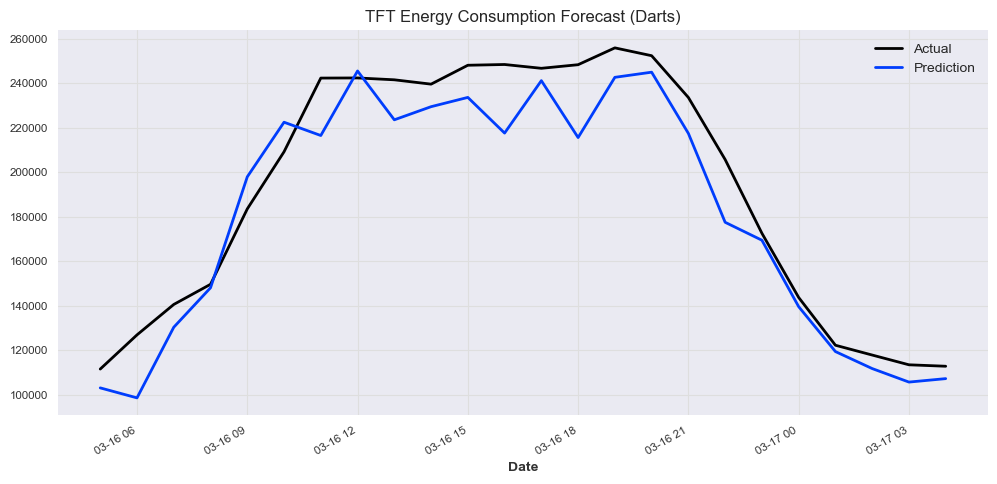

Target dtype: float32


In [16]:

# ---- PLOT ----
plt.figure(figsize=(12, 5))
actual.plot(label="Actual")
pred.plot(label="Prediction")
plt.legend()
plt.title("TFT Energy Consumption Forecast (Darts)")
plt.show()

# ---- SON KONTROL ----
print("Target dtype:", target_series.dtype)
